# Introuducción

Este dataset fue creado y donado por ZeMA GmbH, un centro de investigación y desarrollo en mecatrónica y tecnologías de automatización ubicado en Alemania.

El dataset fue recopilado realizando (experimentalmente) ciclos sucesivos de 60 segundos de duración sobre un Rig Hidráulico. El Rig consiste en un circuito primario de trabajo, y un circuito secundario de enfriamiento/filtración que se conectan a traves de un tanque de aceite. 

<br />

<div style="clear: both">
<img src="img/System.png" style="width: 1000px;float:left">
</div>

<div style="clear: both">
</div>

<br />

El sistema repite ciclos de trabajo variando el estado de 4 componentes mientras se miden diferentes señales de proceso.
El objetivo es poder predecir el estado / condición de los componentes a partir de las señales de proceso.


Componentes:
* Enfriador. 3 clases: Eficiencia optima, eficiencia reducida, riesgo de falla total.
* Valvula. 4 clases: comportamiento de apertura y cierre optimo, retraso / atascamiento leve, retraso severo, riesgo de falla total.
* Fugas internas en bomba. 3 clases: sin fugas, pequeñas fugas, fugas severas.
* Presión en acumulador hidráulico. 4 clases: presión óptima, presión levemente reducida, presión severamente reducida, cercano a falla total.


In [206]:
import pickle as pkl
import pandas as pd
import numpy as np
from scipy import stats


%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (20, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 20

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils.vis_utils import plot_model
from funpymodeling.exploratory import status, freq_tbl, profiling_num

In [2]:
path = './dataset/'

with open(path+ 'df_data_structured.pkl','rb') as file:
    df_x=pkl.load(file)

with open(path + 'df_output_structured.pkl','rb') as file:
    df_y=pkl.load(file)

# Analisis básico de datos


## Señales de entrada

* Tamaño del dataset.
* Imprimir los nombres de las señales.
* Imprimir la primera fila de las señales.
* Imprimir los tipos de datos de cada señal.
* Graficar las señales.
* Obtener estadísticos básicos.

In [3]:
#Tamaño del dataset
[df_x.shape, len(df_x.dtype.names)]

[(2205, 6000), 17]

El dataset posee la medición de 2205 ciclos de 17 señales con 6000 puntos cada ciclo. 

In [4]:
#Señales de entrada
df_x.dtype.names

('PS1',
 'PS2',
 'PS3',
 'PS4',
 'PS5',
 'PS6',
 'EPS1',
 'FS1',
 'FS2',
 'TS1',
 'TS2',
 'TS3',
 'TS4',
 'VS1',
 'SE',
 'CE',
 'CP')

Las señales medidas son:
- 6 presiones en bar en diferentes zonas. PS1-PS6
- Potencia de bomba principal. EPS1
- Flujo (estimo en circuito primario y secundario). FS1 FS2
- 4 temperaturas en diferentes zonas. TS1 - TS4
- Vibraciones. VS1
- Eficiencia de enfriamiento. CE
- Potencia de enfriamiento. CP
- Factor de eficiencia. SE

In [5]:
# Vemos tipos de datos
df_x[0]

array([(151.47000122, 125.5       , 2.30500007, 0., 9.93599987, 9.81799984, 2411.60009766, 8.98999977, 10.1789999, 35.56999969, 40.96099854, 38.31999969, 30.36300087, 0.60399997, 68.03900146, 47.20199966, 2.18400002),
       (151.44999695, 125.38999939, 2.30500007, 0., 9.94699955, 9.82299995, 2411.60009766,        nan,        nan,         nan,         nan,         nan,         nan,        nan,         nan,         nan,        nan),
       (151.52000427, 125.40000153, 2.33599997, 0., 9.96399975, 9.84399986, 2411.60009766,        nan,        nan,         nan,         nan,         nan,         nan,        nan,         nan,         nan,        nan),
       ...,
       (151.1000061 , 125.11000061, 2.25      , 0., 9.74499989, 9.63899994, 2409.60009766,        nan,        nan,         nan,         nan,         nan,         nan,        nan,         nan,         nan,        nan),
       (151.21000671, 125.13999939, 2.25      , 0., 9.73999977, 9.63399982, 2409.60009766,        nan,        nan,  

Todos los valores se representan como números de punto flotante.

Observamos la presencia de nan, analizaremos luego en profundidad la causa.

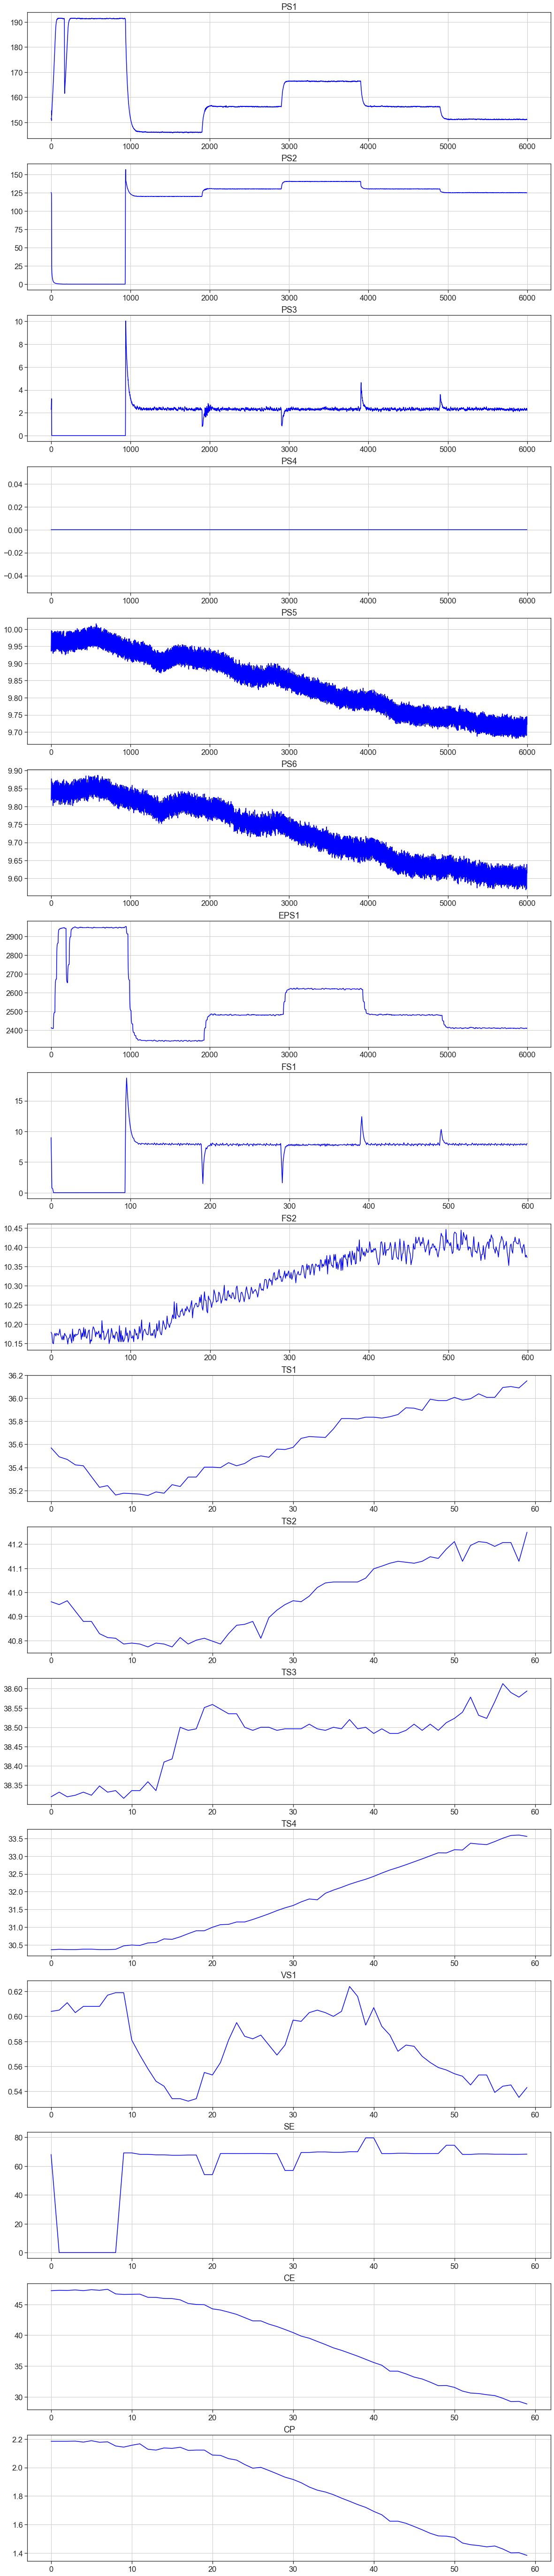

In [6]:
# Grafico de señales
fig, axs = plt.subplots(17,figsize=(20, 100))
for i,col in enumerate(df_x.dtype.names):
    signal= df_x[col][0,:]
    axs[i].plot(signal[~np.isnan(signal)],color='blue',label=None)
    axs[i].set_title(col)
    axs[i].grid()

In [7]:
# Estadisticos
for col in df_x.dtype.names:
    print("----------------------------------------")
    print(col)
    print(f'nan: {np.sum(np.isnan(df_x[col]))}')
    print(f'unique: {len(np.unique(df_x[col]))}')
    print(f'min: {np.nanmin(df_x[col])}')
    print(f'max: {np.nanmax(df_x[col])}')
    print(f'mean: {np.nanmean(df_x[col])}')
    print(f'std: {np.nanstd(df_x[col])}')

----------------------------------------
PS1
nan: 0
unique: 4581
min: 133.1300048828125
max: 191.9199981689453
mean: 160.4853148787345
std: 16.13333028163704
----------------------------------------
PS2
nan: 0
unique: 12100
min: 0.0
max: 167.77000427246094
mean: 109.37990626819101
std: 48.10317157402828
----------------------------------------
PS3
nan: 0
unique: 1096
min: 0.0
max: 18.827999114990234
mean: 1.7532274926304299
std: 0.9347073805518215
----------------------------------------
PS4
nan: 0
unique: 8145
min: 0.0
max: 10.265999794006348
mean: 2.600265957945768
std: 4.297607137777727
----------------------------------------
PS5
nan: 0
unique: 1495
min: 8.317999839782715
max: 10.041000366210938
mean: 9.163320087504657
std: 0.5765989263674267
----------------------------------------
PS6
nan: 0
unique: 1433
min: 8.267999649047852
max: 9.90999984741211
mean: 9.079362751920243
std: 0.54992710636848
----------------------------------------
EPS1
nan: 0
unique: 4404
min: 2097.80004882812

## Salidas

In [8]:
df_y.dtype.names

('CoolerCondition',
 'ValveCondition',
 'Internal Pump Leakage',
 'HydraulicAcumulator',
 'StableFlag')

En este caso StableFlag no se analiza por no ser un componente que se varía su condició, la descartamos.

In [116]:
df_y=df_y[np.array(df_y.dtype.names)[:-1]]

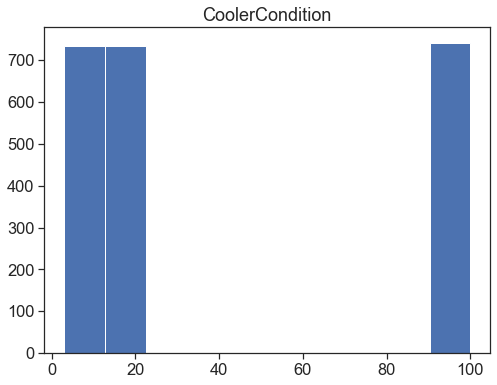

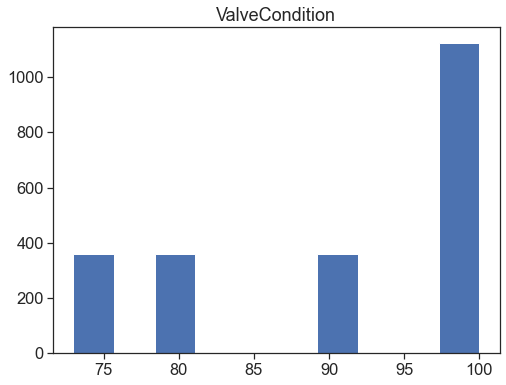

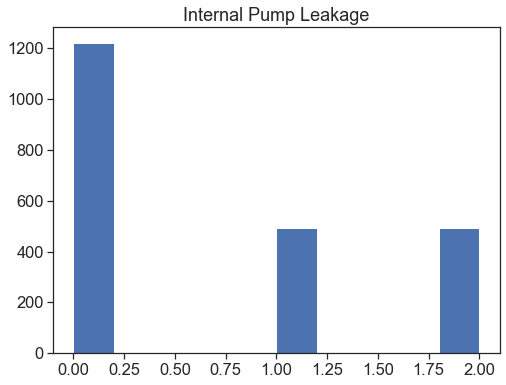

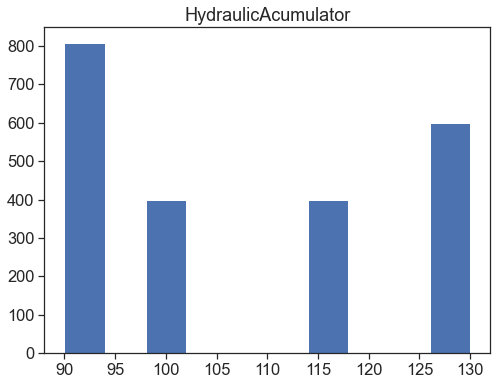

In [117]:
for col in df_y.dtype.names:
    output = df_y[col]
    fig, ax = plt.subplots(1,figsize=(8,6))
    ax.hist(output)
    ax.set_title(col)

# DECIDIR CODIFICACION DIFERENTE?

Por lo que se puede observar el problema presenta 4 salidas con valores numéricos que representan la condición de los componentes.
El problema global se puede dividir entonces como 4 problemas de clasificación multiclase.

# Limpieza de datos

*   Analizar la cantidad de NaNs
*   Darle un tratamiento a los NaNs
*   Verificar no modificar las distribuciones




In [10]:
# Imprimo cantidad de nan por señal
for col in df_x.dtype.names:
    print(f'{col} nan: {np.sum(np.isnan(df_x[col]))}')

PS1 nan: 0
PS2 nan: 0
PS3 nan: 0
PS4 nan: 0
PS5 nan: 0
PS6 nan: 0
EPS1 nan: 0
FS1 nan: 11907000
FS2 nan: 11907000
TS1 nan: 13097700
TS2 nan: 13097700
TS3 nan: 13097700
TS4 nan: 13097700
VS1 nan: 13097700
SE nan: 13097700
CE nan: 13097700
CP nan: 13097700


In [11]:
# Analizo los primeros valores de FS1 
df_x['FS1'][0,0:100]

array([8.98999977e+00,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan, 7.69999981e-01,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
       6.40999973e-01,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan, 6.00000005e-03,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
       0.00000000e+00,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan, 0.00000000e+00,            nan,
                  nan,            nan,            nan,            nan,
      

In [12]:
np.argwhere(~np.isnan(df_x['FS1'][0,:])).T

array([[   0,   10,   20,   30,   40,   50,   60,   70,   80,   90,  100,
         110,  120,  130,  140,  150,  160,  170,  180,  190,  200,  210,
         220,  230,  240,  250,  260,  270,  280,  290,  300,  310,  320,
         330,  340,  350,  360,  370,  380,  390,  400,  410,  420,  430,
         440,  450,  460,  470,  480,  490,  500,  510,  520,  530,  540,
         550,  560,  570,  580,  590,  600,  610,  620,  630,  640,  650,
         660,  670,  680,  690,  700,  710,  720,  730,  740,  750,  760,
         770,  780,  790,  800,  810,  820,  830,  840,  850,  860,  870,
         880,  890,  900,  910,  920,  930,  940,  950,  960,  970,  980,
         990, 1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090,
        1100, 1110, 1120, 1130, 1140, 1150, 1160, 1170, 1180, 1190, 1200,
        1210, 1220, 1230, 1240, 1250, 1260, 1270, 1280, 1290, 1300, 1310,
        1320, 1330, 1340, 1350, 1360, 1370, 1380, 1390, 1400, 1410, 1420,
        1430, 1440, 1450, 1460, 1470, 

Observamos que FS1 está muestreada cada 10 muestras de PS1.
Los nan se corresponden a momentos donde no se muestrea la señal por tener diferentes frecuencias de adquisición.

* FS1 y FS2 están muestreadas a una frecuencia 10 veces menor a PS1

In [13]:
np.argwhere(~np.isnan(df_x['TS1'][0,:])).T

array([[   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000,
        1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100,
        2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200,
        3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300,
        4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400,
        5500, 5600, 5700, 5800, 5900]], dtype=int64)

* TS1 a TS4, VS1, SE, CE, y CP están muestreadas a una frecuencia 100 veces menor a PS1.

Para tratar los NaN podemos submuestrear todas las señales a la frecuencia mas baja, pero perderíamos muchos datos en el proceso. Se opta por rellenar los NaN con interpolaciones.

In [14]:
# Relleno NaN con valores interpolados
for col in df_x.dtype.names:
    aux = pd.DataFrame(df_x[col].transpose()) 
    aux = aux.interpolate()
    aux = np.array(aux).transpose()
    df_x[col] = aux

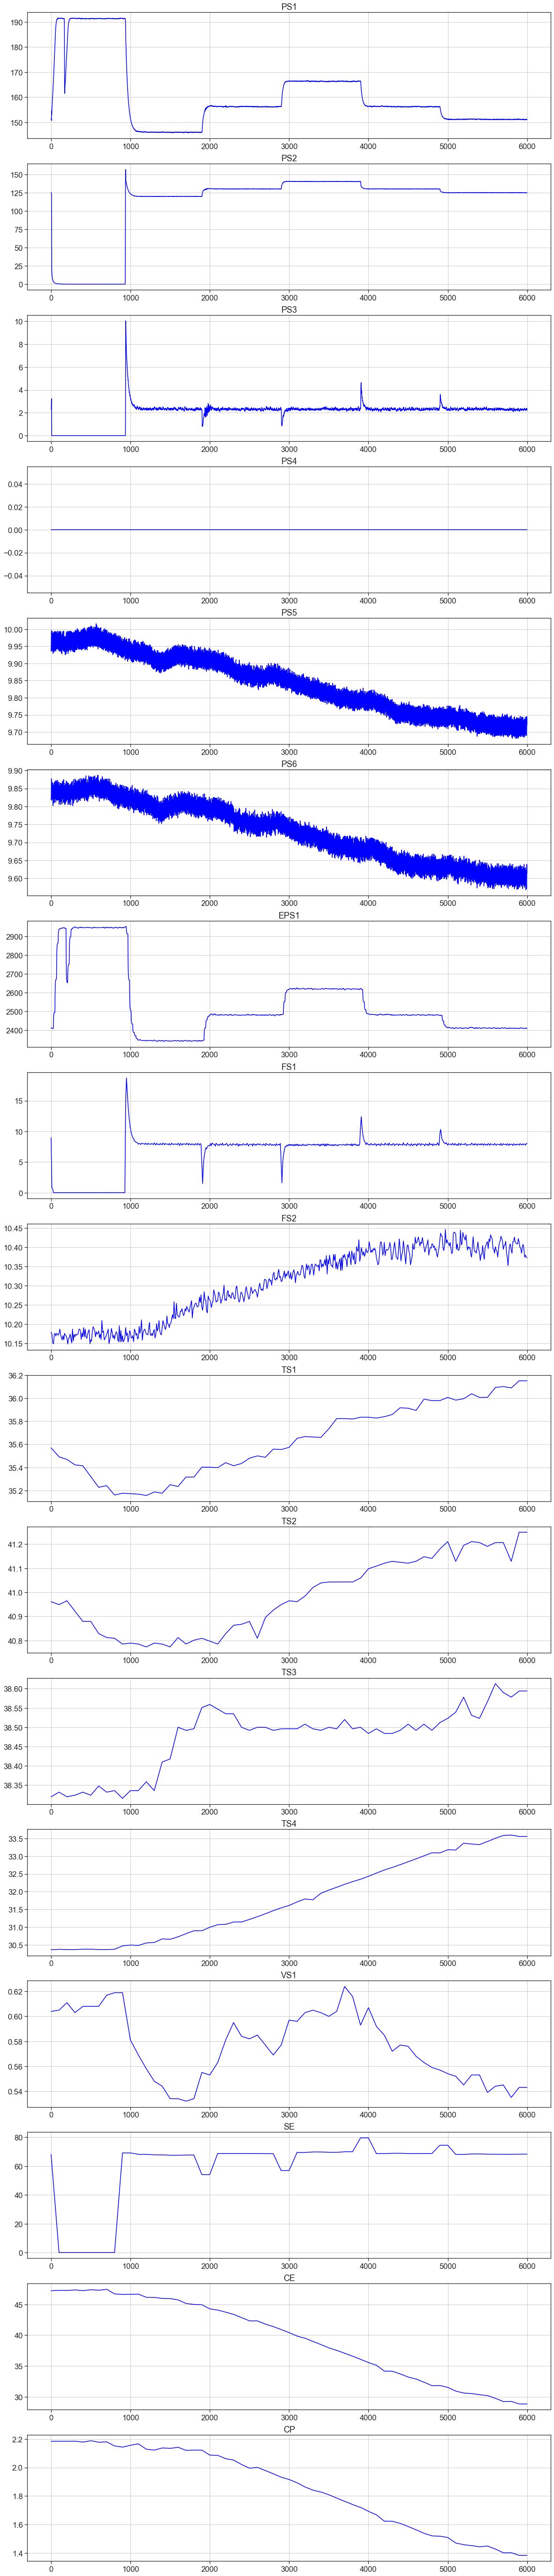

In [15]:
# Grafico nuevamente las señales
fig, axs = plt.subplots(17,figsize=(20, 100))
for i,col in enumerate(df_x.dtype.names):
    signal= df_x[col][0,:]
    axs[i].plot(signal[~np.isnan(signal)],color='blue',label=None)
    axs[i].set_title(col)
    axs[i].grid()

In [16]:
# Chequeo nuevas estadisticas
for col in df_x.dtype.names:
    print("----------------------------------------")
    print(col)
    print(f'nan: {np.sum(np.isnan(df_x[col]))}')
    print(f'unique: {len(np.unique(df_x[col]))}')
    print(f'min: {np.nanmin(df_x[col])}')
    print(f'max: {np.nanmax(df_x[col])}')
    print(f'mean: {np.nanmean(df_x[col])}')
    print(f'std: {np.nanstd(df_x[col])}')

----------------------------------------
PS1
nan: 0
unique: 4581
min: 133.1300048828125
max: 191.9199981689453
mean: 160.4853148787345
std: 16.13333028163704
----------------------------------------
PS2
nan: 0
unique: 12100
min: 0.0
max: 167.77000427246094
mean: 109.37990626819101
std: 48.10317157402828
----------------------------------------
PS3
nan: 0
unique: 1096
min: 0.0
max: 18.827999114990234
mean: 1.7532274926304299
std: 0.9347073805518215
----------------------------------------
PS4
nan: 0
unique: 8145
min: 0.0
max: 10.265999794006348
mean: 2.600265957945768
std: 4.297607137777727
----------------------------------------
PS5
nan: 0
unique: 1495
min: 8.317999839782715
max: 10.041000366210938
mean: 9.163320087504657
std: 0.5765989263674267
----------------------------------------
PS6
nan: 0
unique: 1433
min: 8.267999649047852
max: 9.90999984741211
mean: 9.079362751920243
std: 0.54992710636848
----------------------------------------
EPS1
nan: 0
unique: 4404
min: 2097.80004882812

**Se corrobora que la interpolación no ha deformado las distribuciones**

# Esquema de validación de resultados

Particionaremos el dataset en entrenamiento y testeo (80-20). 

Sobre la partición de entrenamiento aplicaremos KFolds con 5 grupos para realizar el ajuste fino de hiperparámetros de modelo y obtener las métricas de validación.

Una vez ajustado los modelos, haremos un cálculo final de performance sobre el dataset de testeo.

In [44]:
x_train, x_test, y_train, y_test = train_test_split( df_x, df_y, test_size=0.2, shuffle=True)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1764, 6000)
(1764,)
(441, 6000)
(441,)


# Ingeniería de features básica

Trabajar directamente con las señales crudas sería problemático ya están sujetas a una gran cantidad de variables que las hacen difíciles de analizar; para mencionar algunas: gran dimensionalidad (6000 muestras por 17 señales equivalen a 102000 features) ruido de campo y de medición añadido, desvíos progresivos en los sensores, corrimientos en tiempo (retrasos) que afectan la correlación entre features, etc. 

Por este motivo se decide realizar la siguiente transformación:
- Se divide cada señal en 5 segmentos. El valor 5 se seleccionó en forma aleatoria y sería un hiperparámetro en el caso de querer optener el modelo con mejores resultados.

- Sobre cada segmento se aplican estadísticos. En este caso tomaremos: media, desviación estándar, oblicuidad y kurtosis. La cantidad de estadísticos tomados también se puede pensar como un hiperparámetro.


Una vez hecha la transformación pasaremos de un dataset de 2205 muestras, 6000 puntos y 17 señales a un dataset de 2205 muestras con 340 features (17 señales x 5 segmentos x 4 estadísticos). 

Sobre este dataset transformado, se harán los siguientes análisis:

* Correlaciones.
* Relación con la salida.
* plot-box de las variables mas correlacionadas con la salida

In [46]:
# Dataset de características
df_train_char = pd.DataFrame()

n_sectors = 5
step = int(x_train.shape[1]/n_sectors)

for col in x_train.dtype.names:
    for i in range(0,n_sectors):
        df_train_char[f'Mean {i} - {col}']=np.mean(x_train[col][:,(i*step):((i+1)*step)],axis=1)
        df_train_char[f'Std {i} - {col}']=np.std(x_train[col][:,(i*step):((i+1)*step)],axis=1)
        df_train_char[f'Kurtosis {i} - {col}']=stats.kurtosis(x_train[col][:,(i*step):((i+1)*step)],axis=1)
        df_train_char[f'Skew {i} - {col}']=stats.skew(x_train[col][:,(i*step):((i+1)*step)],axis=1)

In [47]:
df_train_char

,Mean 0 - PS1,Std 0 - PS1,Kurtosis 0 - PS1,Skew 0 - PS1,Mean 1 - PS1,Std 1 - PS1,Kurtosis 1 - PS1,Skew 1 - PS1,Mean 2 - PS1,Std 2 - PS1,...,Kurtosis 2 - CP,Skew 2 - CP,Mean 3 - CP,Std 3 - CP,Kurtosis 3 - CP,Skew 3 - CP,Mean 4 - CP,Std 4 - CP,Kurtosis 4 - CP,Skew 4 - CP
0,180.685175,17.842948,-0.119626,-1.314036,148.013508,4.840571,-1.818944,0.399895,159.656367,4.945830,...,0.018971,-1.183431,1.768512,0.017025,-1.320064,-0.123594,1.754695,0.011004,-1.524066,-0.100065
1,178.653851,19.000697,-0.292107,-1.251925,158.511442,22.263331,-1.646823,0.546427,188.583900,0.092457,...,-0.539008,0.202545,1.554985,0.016870,-1.506521,-0.475131,1.593658,0.012007,-1.091783,0.073383
2,178.136792,19.118485,-0.358325,-1.223923,158.120775,22.249468,-1.638902,0.551530,188.361774,0.097602,...,-1.280219,-0.236096,1.489864,0.009744,-1.160153,-0.609580,1.505201,0.007433,-1.421738,0.247710
3,180.086367,18.527592,-0.249047,-1.273849,147.326925,4.821587,-1.827819,0.392339,158.959984,4.932967,...,-1.196107,-0.648425,1.700093,0.011220,0.613001,-1.234945,1.689410,0.003135,0.442661,-0.242044
4,180.087958,18.480984,-0.265571,-1.268015,147.463709,4.829773,-1.828958,0.391599,159.079792,4.929937,...,-0.813961,-0.803265,1.709668,0.009357,-0.848655,0.097768,1.705662,0.004410,1.571973,1.500495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1759,181.179518,17.400750,-0.276794,-1.253994,150.526658,4.701816,-1.824905,0.394761,161.831625,4.828146,...,-0.193034,-0.661611,2.125775,0.008278,0.304348,-0.862269,2.136335,0.003399,-0.755641,-0.597693
1760,179.162699,18.883923,-0.229513,-1.269986,146.316150,5.140013,-1.863424,0.355171,157.770342,4.732956,...,-0.594957,0.800787,1.525037,0.015708,-1.021069,-0.479923,1.559722,0.016786,0.162826,-0.896208
1761,181.757509,17.113384,-0.092542,-1.327671,150.520033,4.652589,-1.816953,0.401807,161.892659,4.896551,...,-0.729449,0.594684,2.153131,0.009468,0.129040,-1.276897,2.142406,0.009211,0.381540,1.255063
1762,182.028859,17.142760,-0.008364,-1.365597,150.740667,4.749819,-1.827170,0.393750,162.109659,4.789106,...,-0.387621,-0.059896,2.160101,0.014175,-0.604275,-0.510195,2.136912,0.003732,-0.256438,0.680508


In [48]:
# Correlaciones
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

corr = df_train_char.corr().abs().unstack()
labels_to_drop = get_redundant_pairs(df_train_char)
corr = corr.drop(labels=labels_to_drop).sort_values(ascending=False)

In [32]:
corr[corr>0.9]

Mean 2 - PS5  Mean 2 - PS6        0.999992
Mean 4 - PS5  Mean 4 - PS6        0.999992
Mean 0 - PS5  Mean 0 - PS6        0.999992
Mean 3 - PS5  Mean 3 - PS6        0.999992
Mean 1 - PS5  Mean 1 - PS6        0.999992
                                    ...   
Mean 0 - PS1  Mean 0 - FS2        0.900126
Mean 3 - TS3  Mean 0 - CP         0.900121
Mean 1 - TS1  Mean 4 - CP         0.900098
Mean 0 - PS1  Mean 2 - FS2        0.900080
Mean 1 - PS2  Kurtosis 1 - PS2    0.900018
Length: 2651, dtype: float64

In [40]:
corr[(corr>0.6) &  (corr<0.9)]

Std 4 - EPS1      Std 3 - SE         0.899997
Skew 2 - PS3      Std 1 - SE         0.899994
Mean 2 - TS3      Mean 0 - CP        0.899906
Mean 2 - PS2      Kurtosis 4 - SE    0.899886
Mean 2 - TS2      Mean 4 - CP        0.899837
                                       ...   
Std 0 - EPS1      Std 4 - FS2        0.600068
Kurtosis 1 - TS1  Skew 1 - TS1       0.600051
Kurtosis 4 - FS1  Std 3 - SE         0.600032
Std 2 - FS2       Mean 2 - SE        0.600032
Std 4 - PS6       Mean 4 - CP        0.600013
Length: 4633, dtype: float64

In [41]:
corr[(corr<0.6)]

Mean 1 - EPS1     Mean 1 - TS1    0.599992
Std 2 - PS5       Mean 2 - CP     0.599942
Std 3 - PS1       Std 0 - FS2     0.599923
Std 2 - PS5       Mean 1 - CP     0.599913
Kurtosis 3 - FS1  Mean 4 - TS4    0.599859
                                    ...   
Kurtosis 3 - PS4  Mean 2 - PS5    0.000011
Mean 0 - FS1      Skew 4 - TS3    0.000010
Skew 2 - PS3      Skew 2 - PS4    0.000009
Kurtosis 0 - TS1  Skew 0 - SE     0.000005
Skew 2 - PS4      Skew 2 - VS1    0.000002
Length: 50346, dtype: float64

Observamos que dada la naturaleza de las features existe gran correlación entre muchas de ellas. En especial entre diferentes estadísticos calculados sobre el mismo segmento de la misma señal (ejemplo media 1 y kurtosis 1 PS2) y entre el mismo estadístico calculado en el mismo segmento entre diferentes señales correlacionadas (ejemplo PS5 y PS6).

También se observan algunas correlaciones a priori no intuitivas como Mean 0 PS1 y Mean 2 FS2 que son estadísticos de dos magnitudes físicas distintas, de momentos de tiempo diferentes y de circuitos diferentes (primario y secundario). Casos como estos requerirían un análisis experto de el modelo matemático del rig.

La conclusión que se obtiene de las correlaciones es que resultaría de gran beneficio hacer una selección de variables previo al entrenamiento de modelos. Esto no solo disminuiría el costo computacional sino que mejoraría la inmunidad del modelo a ruido, ausencia de variables, entre otras cosas.

# REVISAR

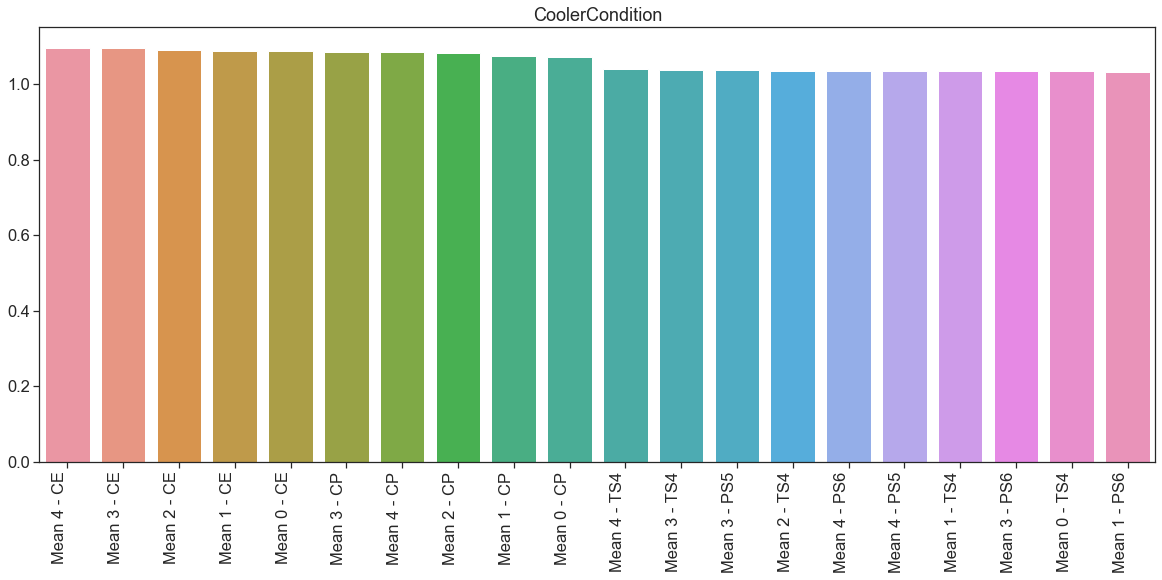

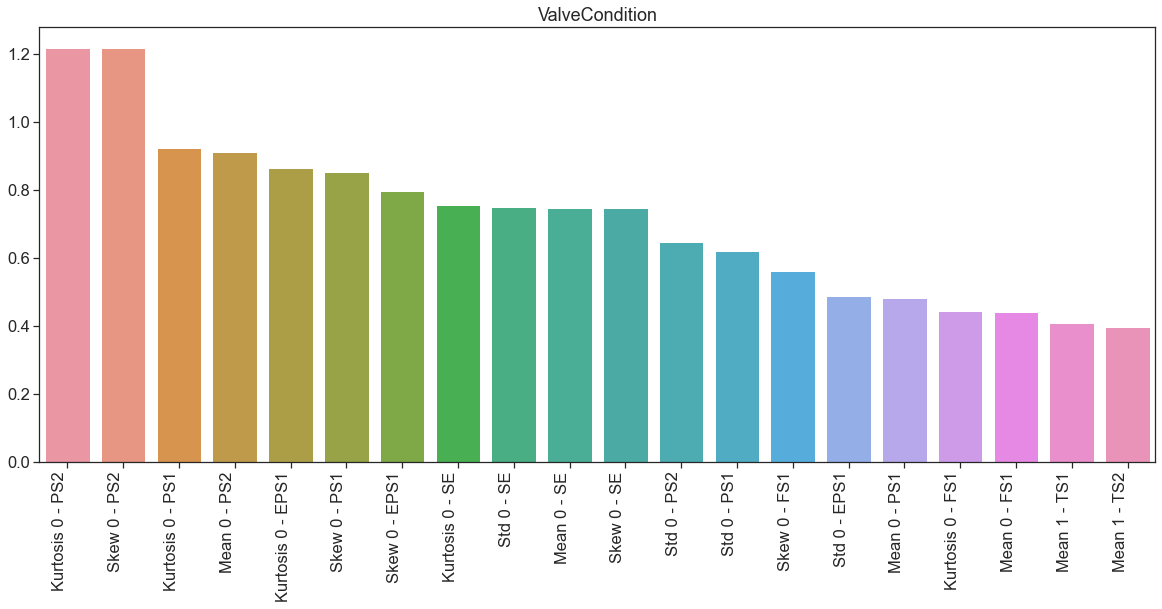

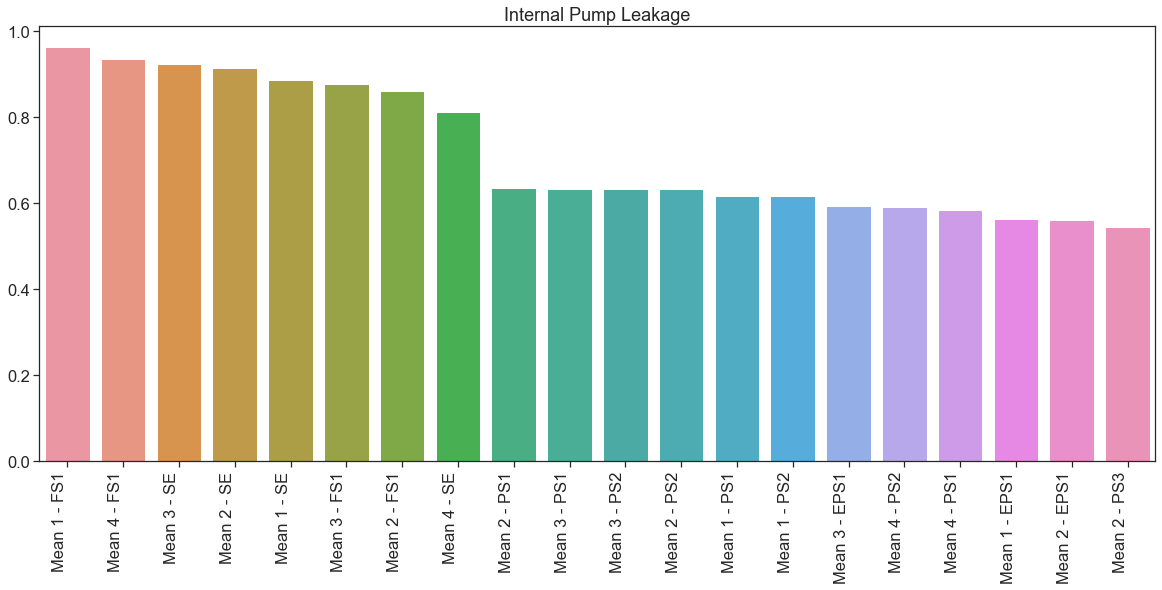

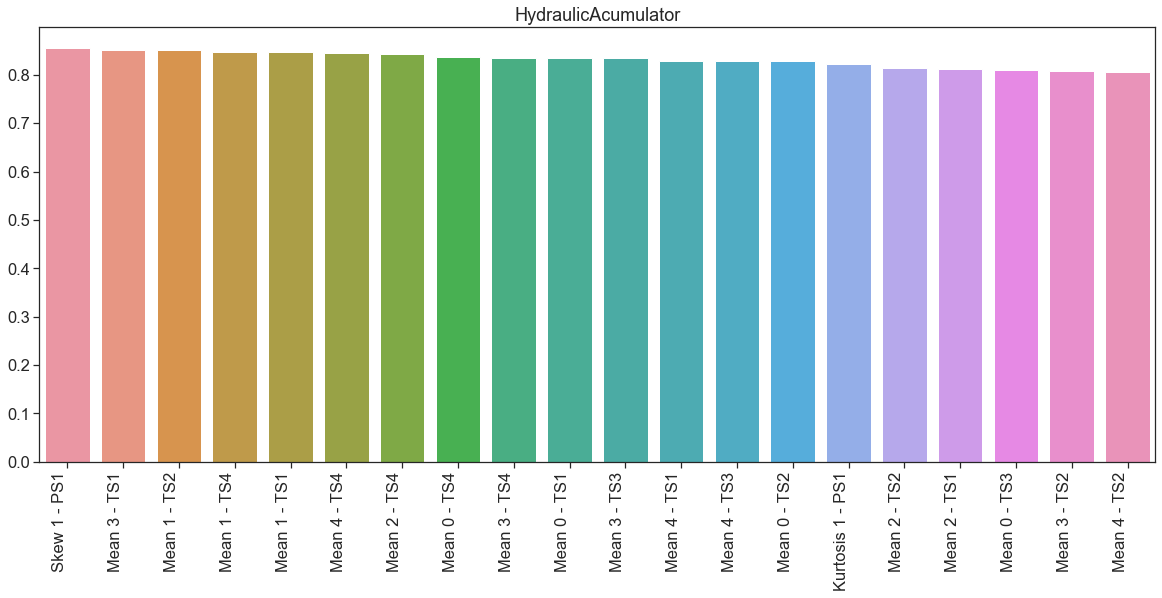

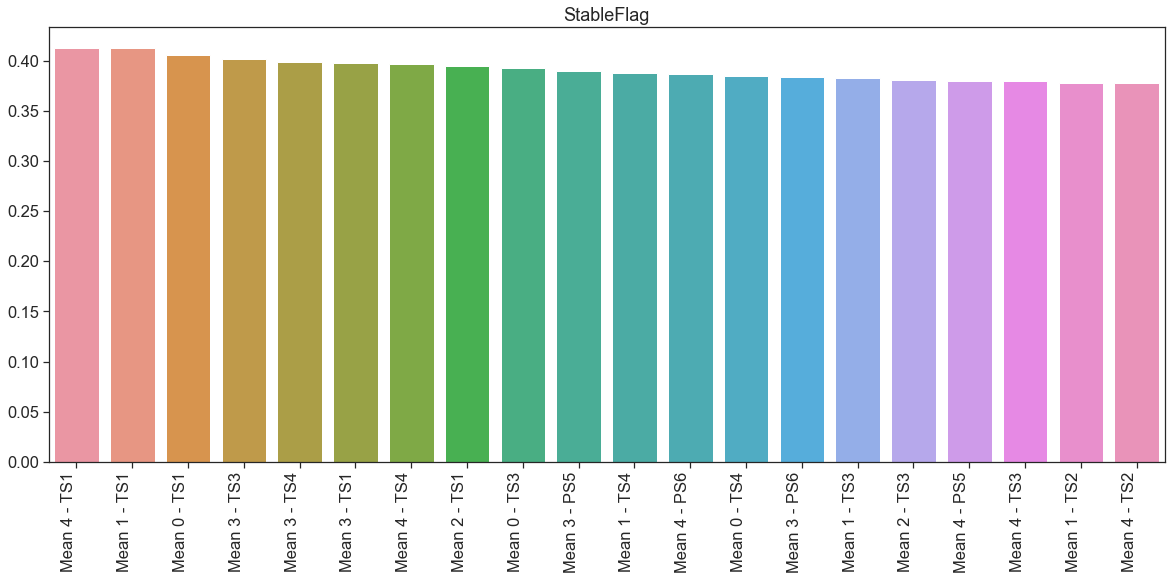

In [121]:
# Relación con la salida
mutual_info_top_signals=[]

def select_features_mutual_info(X_train, y_train,k= 'all'):  
    fs = SelectKBest(score_func=mutual_info_classif, k=k )  
    fs.fit(X_train, y_train)  
    return fs

for ycol in y_train.dtype.names:
    fs = select_features_mutual_info(df_train_char, y_train[ycol],20)
    kfeatures= np.argsort(fs.scores_)[-1:-21:-1]
    fig,axes = plt.subplots(1,1,figsize=(20,8))
    bar = sns.barplot( x = df_train_char.columns[kfeatures] , y = fs.scores_[kfeatures],ax=axes)
    bar.set_xticklabels(bar.get_xticklabels(), rotation=90, horizontalalignment='right')
    bar.set_title(ycol)
    plt.show()
    mutual_info_top_signals.append(df_train_char.columns[kfeatures])

Aplicando información mutua, se obtiene:

- Para la condición del cooler, resultan importantes la media de CE (señal "virtual") que aproxima la eficiencia del enfriamiento, la media de la potencia del enfriador y la media de la temperatura TS4. Analizando el sistema parece ser correcto.

- Para la condición de la válvula, son importantes la kurtosis y oblicuidad en el primer segmento de PS2. Esto tiene sentido,  ya que la válvula en cuestión es la que abre el circuito para que se levante presión en PS2 en el instante 1000 aproximadamente.

- Para las perdidas en la bomba principal, se marca como importante la media de FS1 que es el caudal de aceite por el circuito principal.

- Para el nivel en el acumulador de reserva, se marca como importante la oblicuidad de PS1 y las medias de las distintas temperaturas. Este correlación ya es dificil de interpretar contra el análisis del sistema.

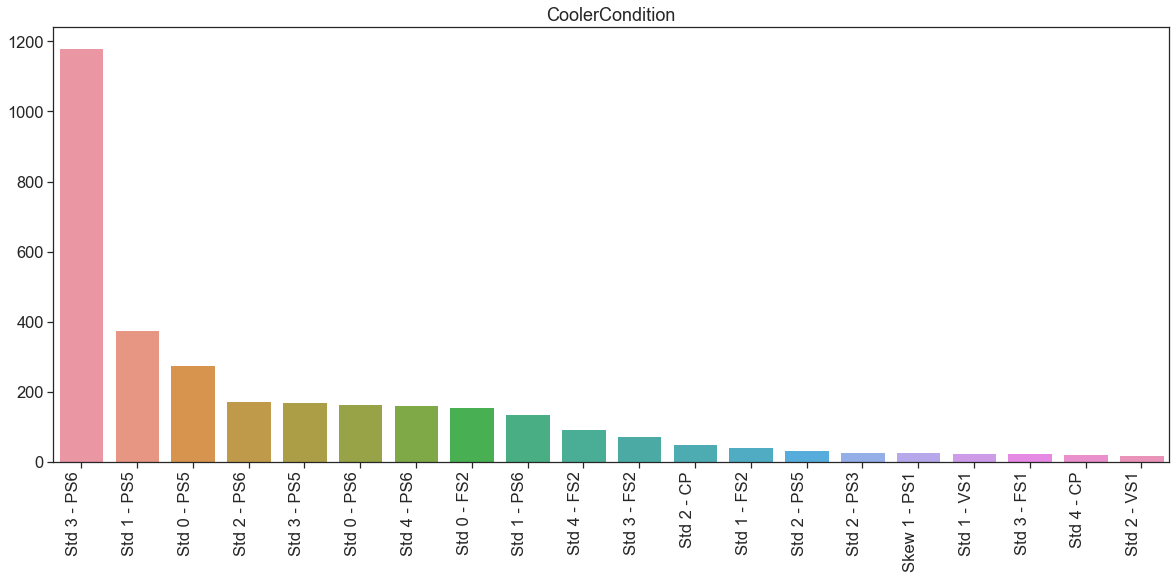

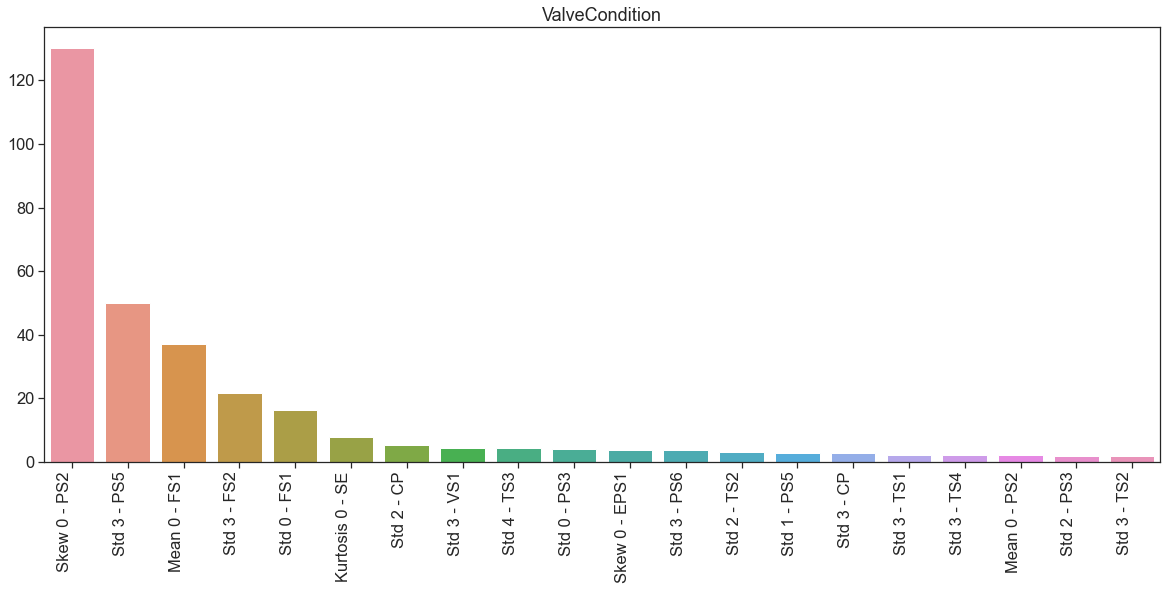

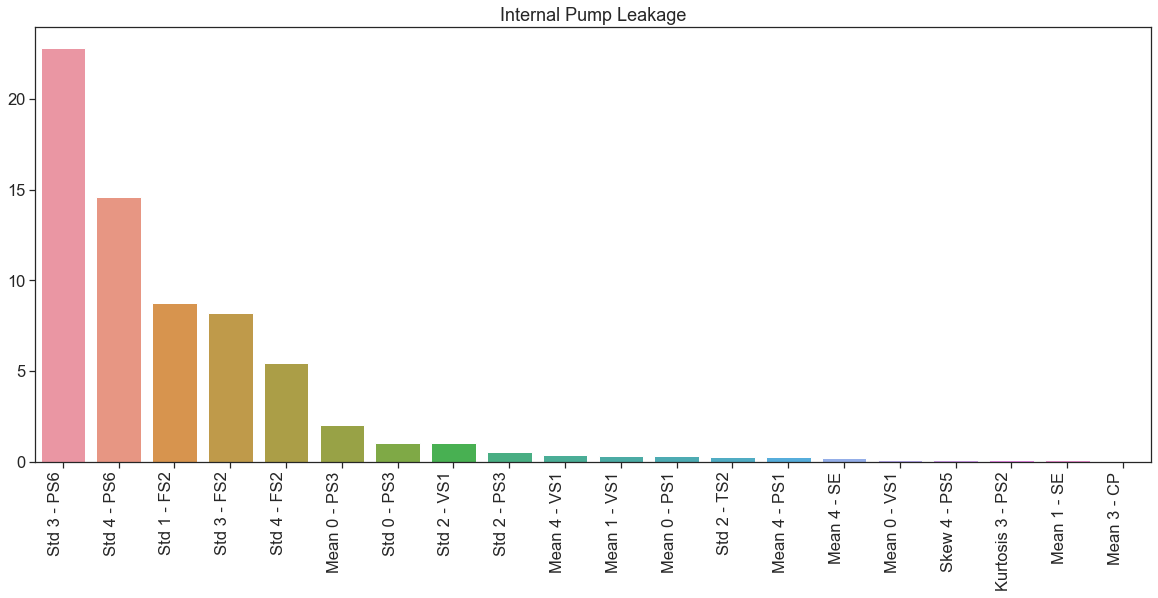

C:\Users\MaxiT\.conda\envs\CEIAIIA\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 128.7743040984642, tolerance: 47.406218820861696
  model = cd_fast.enet_coordinate_descent(


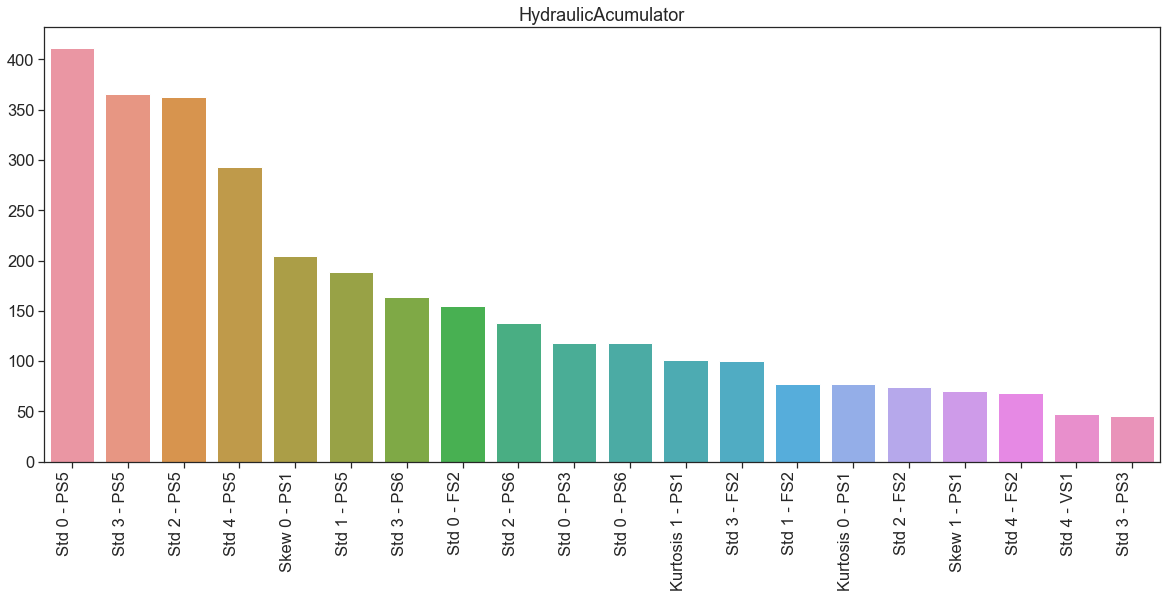

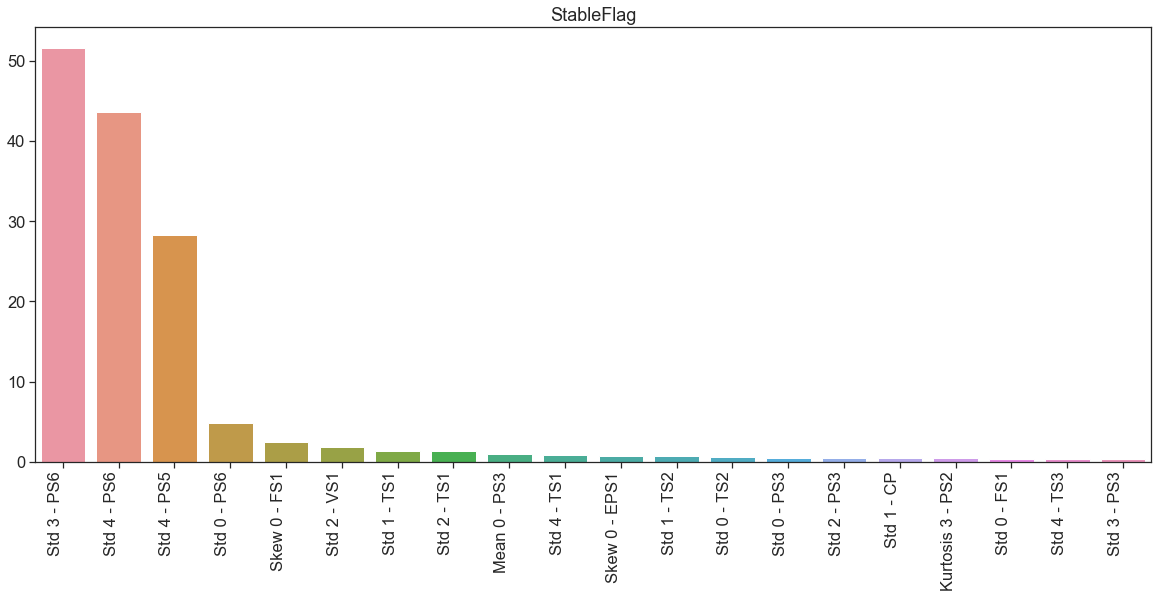

In [129]:
# Ahora utilizamos lasso para comprobar las relaciones con otro método
lasso_top_signals=[]

for ycol in y_train.dtype.names:
    lassoreg = Lasso(alpha=0.0001,normalize=True, max_iter=10000)
    lassoreg.fit(df_train_char, y_train[ycol])
    kfeatures= np.argsort(np.abs(lassoreg.coef_))[-1:-21:-1]
    fig,axes = plt.subplots(1,1,figsize=(20,8))
    bar = sns.barplot( x = df_train_char.columns[kfeatures] , y = np.abs(lassoreg.coef_[kfeatures]),ax=axes)
    bar.set_xticklabels(bar.get_xticklabels(), rotation=90, horizontalalignment='right')
    bar.set_title(ycol)
    plt.show()
    lasso_top_signals.append(df_train_char.columns[kfeatures])

Aplicando Lasso, se obtiene:

- Para la condición del cooler, resultan importantes la desviación estandar en PS5 y PS6. Se puede llegar a intuir esta correlación teniendo en cuenta que PS5 y PS6 miden la presión antes y después del cooler.

- Para la condición de la válvula, nuevamente es importante la oblicuidad en el primer segmento de PS2. También se marca como importante la desviación estándar en PS5 lo cual no es visible en el circuito físico.

- Para las perdidas en la bomba principal, se marca como importante el desvío estándar en PS6 y la desviación estándar de FS2. Estas correlaciones no son visibles en el circuito físico.

- Para el nivel en el acumulador de reserva, se marca como importante la desviación estandar en PS5 y PS6. Estas correlaciones no son visibles en el circuito físico.

**A partir de lo observado, y a fin de reducir dimensiones, se decide tomar para cada salida las 10 variables de entrada más importantes marcadas por cada método**

In [161]:
top_signals=[]
for i in range(len(mutual_info_top_signals)):
    top_signals.append( np.unique(\
                                  [mutual_info_top_signals[i][0:10], \
                                   lasso_top_signals[i][0:10]]))

In [162]:
top_signals

[array(['Mean 0 - CE', 'Mean 0 - CP', 'Mean 1 - CE', 'Mean 1 - CP',
        'Mean 2 - CE', 'Mean 2 - CP', 'Mean 3 - CE', 'Mean 3 - CP',
        'Mean 4 - CE', 'Mean 4 - CP', 'Std 0 - FS2', 'Std 0 - PS5',
        'Std 0 - PS6', 'Std 1 - PS5', 'Std 1 - PS6', 'Std 2 - PS6',
        'Std 3 - PS5', 'Std 3 - PS6', 'Std 4 - FS2', 'Std 4 - PS6'],
       dtype=object),
 array(['Kurtosis 0 - EPS1', 'Kurtosis 0 - PS1', 'Kurtosis 0 - PS2',
        'Kurtosis 0 - SE', 'Mean 0 - FS1', 'Mean 0 - PS2', 'Mean 0 - SE',
        'Skew 0 - EPS1', 'Skew 0 - PS1', 'Skew 0 - PS2', 'Std 0 - FS1',
        'Std 0 - PS3', 'Std 0 - SE', 'Std 2 - CP', 'Std 3 - FS2',
        'Std 3 - PS5', 'Std 3 - VS1', 'Std 4 - TS3'], dtype=object),
 array(['Mean 0 - PS3', 'Mean 1 - FS1', 'Mean 1 - SE', 'Mean 2 - FS1',
        'Mean 2 - PS1', 'Mean 2 - SE', 'Mean 3 - FS1', 'Mean 3 - PS1',
        'Mean 3 - SE', 'Mean 4 - FS1', 'Mean 4 - SE', 'Mean 4 - VS1',
        'Std 0 - PS3', 'Std 1 - FS2', 'Std 2 - PS3', 'Std 2 - VS1',
       

# Entrenamiento de modelos

In [165]:
results = {}

In [200]:
def EvaluateKFolds(model, X, y, k=5):
    train_auc=0
    valid_auc=0
    
    kf = KFold(n_splits=k)
    kf.get_n_splits(X)
    
    for train_index, valid_index in kf.split(X, y):
        x_valid = X.iloc[valid_index]
        y_valid = y[valid_index]
        x_train = X.iloc[train_index]
        y_train = y[train_index]

        model.fit(x_train, y_train)
        pred_train = model.predict_proba(x_train)
        pred_valid = model.predict_proba(x_valid)
        if len(pred_train.shape)>1 and (pred_train.shape[1]>1):
            train_auc = train_auc + roc_auc_score(y_train, pred_train[:,1],multi_class='ovr') / k
            valid_auc = valid_auc + roc_auc_score(y_valid, pred_valid[:,1],multi_class='ovr') / k
        else:
            train_auc = train_auc + roc_auc_score(y_train, pred_train,multi_class='ovr') / k
            valid_auc = valid_auc + roc_auc_score(y_valid, pred_valid,multi_class='ovr') / k

    return train_auc, valid_auc

## Modelo base

In [201]:
class RandomModel(object):

    def fit(self, X, y):
        return None

    def predict_proba(self, X):
        return np.random.randint(0,1, size=X.shape[0])

In [202]:
for i,ycol in enumerate(y_train.dtype.names):

    model = RandomModel()
    train_auc, valid_auc = EvaluateKFolds(model, df_char_train[top_signals[i]], y_train[ycol], 5)

    results['base']["Train"] = train_auc
    results['base']["Valid"] = valid_auc
    
df_results = pd.DataFrame(results).T
df_results

AxisError: axis 1 is out of bounds for array of dimension 1

## RandomForest

In [208]:

for i,ycol in enumerate(y_train.dtype.names):
    
    enc = OneHotEncoder(handle_unknown='ignore')
    
    y_encoded = enc.fit_transform( y_train[ycol].reshape(-1,1))

    model = model=RandomForestClassifier(n_estimators=200, random_state=5)
    train_auc, valid_auc = EvaluateKFolds(model, df_train_char[top_signals[i]],y_encoded, 5)

    results['base']["Train"] = train_auc
    results['base']["Valid"] = valid_auc
    
df_results = pd.DataFrame(results).T
df_results





ValueError: sparse multilabel-indicator for y is not supported.